In [26]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Load the dataset
# Make sure the 'covid_19_india.csv' file is in the same folder as your Python script
df = pd.read_csv('./archive/covid_19_india.csv')

# --- Data Preparation for Gujarat ---
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Filter data for Gujarat only
gujarat_df = df[df['State/UnionTerritory'] == 'Gujarat'].copy()

# Calculate 'Active' cases which will be our 'Infected' (I) group
# Active = Confirmed - Cured - Deaths
gujarat_df['Active'] = gujarat_df['Confirmed'] - gujarat_df['Cured'] - gujarat_df['Deaths']

# Select a specific period for modeling (e.g., the first wave)
# Let's model for the first 200 days from the first case
gujarat_df = gujarat_df.iloc[0:200]

# Extract the actual data points for Infected (I) and Recovered (R)
infected_actual = gujarat_df['Active'].values
recovered_actual = (gujarat_df['Cured'] + gujarat_df['Deaths']).values
y_data = np.array([infected_actual, recovered_actual]).T # Transpose to get pairs

print("Data for Gujarat prepared. Modeling for the first 200 days.")

Data for Gujarat prepared. Modeling for the first 200 days.


In [27]:
# --- SIR Model Definition ---
# N is the total population of Gujarat (approx. 64 million = 6.4e7)
N = 6.4e7

# The SIR model differential equations.
def sir_model(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [28]:
from scipy.optimize import minimize

# Define a function to calculate the error (Sum of Squared Errors)
# between the model's prediction and the actual data.
def objective_function(params, N, y_data):
    beta, gamma = params
    
    # Initial conditions from the first day of our data
    I0 = y_data[0, 0] # First day's infected count
    R0 = y_data[0, 1] # First day's recovered count
    S0 = N - I0 - R0
    y0 = S0, I0, R0
    
    # Time points (number of days)
    t = np.arange(len(y_data))
    
    # Integrate the SIR equations over the time grid, t.
    solution = odeint(sir_model, y0, t, args=(N, beta, gamma))
    
    # We only care about the Infected (I) and Recovered (R) columns for error calculation
    model_I = solution[:, 1]
    model_R = solution[:, 2]
    
    # Calculate the sum of squared errors
    error_I = np.sum((model_I - y_data[:, 0])**2)
    error_R = np.sum((model_R - y_data[:, 1])**2)
    
    return error_I + error_R

# Initial guess for beta and gamma
initial_guess = [0.2, 0.1]

# Use an optimization function to find the best beta and gamma
# This function tries to minimize the output of 'objective_function'
result = minimize(
    objective_function,
    initial_guess,
    args=(N, y_data),
    method='L-BFGS-B',
    bounds=[(0.001, 1.0), (0.001, 1.0)] # Bounds for beta and gamma
)

beta_optimal, gamma_optimal = result.x
print(f"Optimal Beta (β): {beta_optimal:.4f}")
print(f"Optimal Gamma (γ): {gamma_optimal:.4f}")

Optimal Beta (β): 1.0000
Optimal Gamma (γ): 0.9637


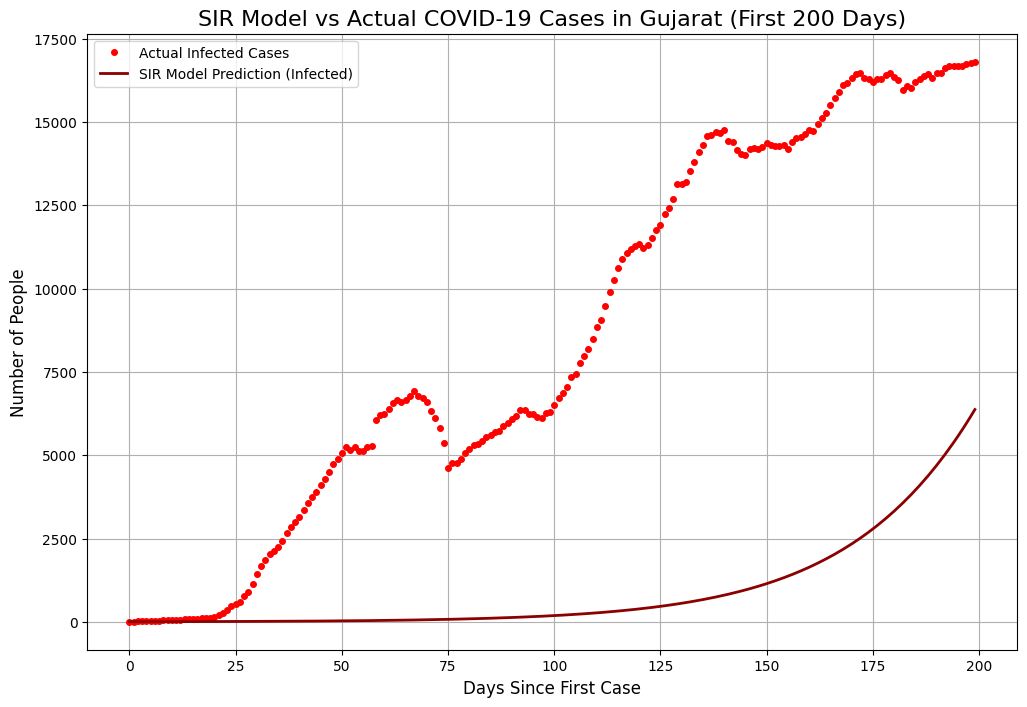

In [29]:
# --- Run Simulation & Plot Results ---
# Time points (number of days in our data)
t = np.arange(len(infected_actual))

# Initial conditions
I0 = infected_actual[0]
R0 = recovered_actual[0]
S0 = N - I0 - R0
y0 = S0, I0, R0

# Integrate the SIR equations over the time grid, t, with the optimal parameters
solution = odeint(sir_model, y0, t, args=(N, beta_optimal, gamma_optimal))
S_pred, I_pred, R_pred = solution.T

# --- Plotting ---
plt.figure(figsize=(12, 8))

# Plot the actual data
plt.plot(t, infected_actual, 'o', label='Actual Infected Cases', color='red', markersize=4)

# Plot the SIR model's prediction
plt.plot(t, I_pred, label='SIR Model Prediction (Infected)', color='darkred', linewidth=2)

# Formatting the plot
plt.title('SIR Model vs Actual COVID-19 Cases in Gujarat (First 200 Days)', fontsize=16)
plt.xlabel('Days Since First Case', fontsize=12)
plt.ylabel('Number of People', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# The same 'sir_model' and 'objective_function' from before are needed.
# Make sure they are defined in your notebook before running this cell.

# --- Define Phases for Sequential Fitting ---
# We split the 200 days into three distinct periods
phases = [
    {'start': 0, 'end': 60},
    {'start': 60, 'end': 120},
    {'start': 120, 'end': 200}
]

# Lists to store results from each phase
full_prediction = []
optimal_params = []

# Initial conditions for the very first phase
I0 = infected_actual[0]
R0 = recovered_actual[0]
S0 = N - I0 - R0
current_y0 = (S0, I0, R0)

print("Starting sequential fitting for each phase...")

# --- Loop Through Each Phase and Fit the Model ---
for phase in phases:
    start_day = phase['start']
    end_day = phase['end']
    
    # Slice the actual data for the current phase
    phase_y_data = y_data[start_day:end_day]
    
    # Time points for this specific phase
    t_phase = np.arange(len(phase_y_data))

    # Find the best beta and gamma for THIS phase
    result = minimize(
        objective_function,
        initial_guess,  # Starting with [0.2, 0.1] each time
        args=(N, phase_y_data),
        method='L-BFGS-B',
        bounds=[(0.001, 1.0), (0.001, 1.0)]
    )
    
    beta_opt, gamma_opt = result.x
    optimal_params.append((beta_opt, gamma_opt))
    
    print(f"Phase {start_day}-{end_day} | Optimal Beta: {beta_opt:.4f}, Optimal Gamma: {gamma_opt:.4f}")
    
    # Run the simulation for this phase using its optimal parameters
    # The initial conditions are the last state of the previous phase
    phase_solution = odeint(sir_model, current_y0, t_phase, args=(N, beta_opt, gamma_opt))
    
    # Store the prediction for this phase
    full_prediction.append(phase_solution)
    
    # Update the initial conditions for the NEXT phase
    current_y0 = phase_solution[-1]

# Combine the predictions from all phases into one continuous array
improved_prediction = np.concatenate(full_prediction)
I_pred_improved = improved_prediction[:, 1]

Starting sequential fitting for each phase...
Phase 0-60 | Optimal Beta: 0.2153, Optimal Gamma: 0.0884
Phase 60-120 | Optimal Beta: 0.0816, Optimal Gamma: 0.1298
Phase 120-200 | Optimal Beta: 0.0848, Optimal Gamma: 0.0785


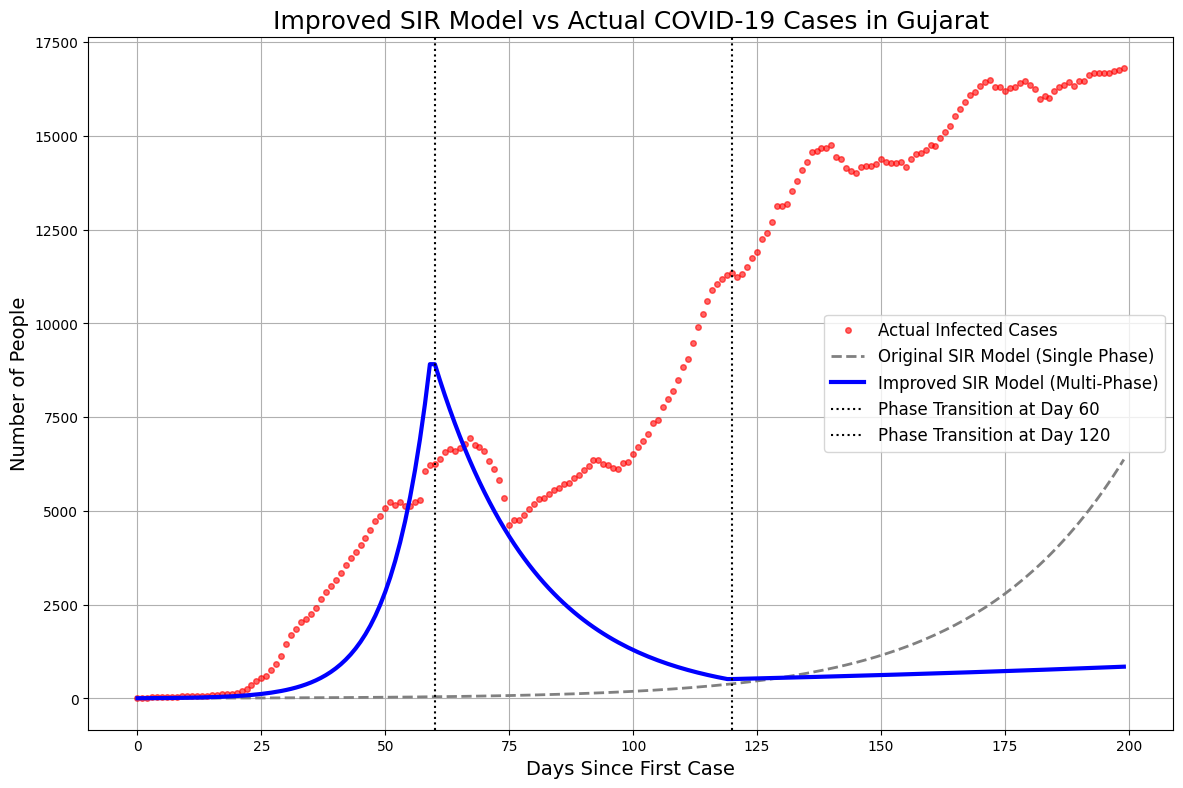

In [31]:
# --- Plotting the Improved Model ---
plt.figure(figsize=(14, 9))

# Plot the actual data points
plt.plot(t, infected_actual, 'o', label='Actual Infected Cases', color='red', markersize=4, alpha=0.6)

# Plot the ORIGINAL simple SIR model prediction (from your first attempt)
plt.plot(t, I_pred, '--', label='Original SIR Model (Single Phase)', color='grey', linewidth=2)

# Plot the NEW IMPROVED multi-phase SIR model prediction
plt.plot(t, I_pred_improved, label='Improved SIR Model (Multi-Phase)', color='blue', linewidth=3)

# Add vertical lines to show the phase transitions
for phase in phases[1:]:
    plt.axvline(x=phase['start'], color='black', linestyle=':', linewidth=1.5, label=f'Phase Transition at Day {phase["start"]}')

# Formatting the plot
plt.title('Improved SIR Model vs Actual COVID-19 Cases in Gujarat', fontsize=18)
plt.xlabel('Days Since First Case', fontsize=14)
plt.ylabel('Number of People', fontsize=14)

# Create a unique legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize=12)

plt.grid(True)
plt.show()